# Домашнее задание 2. Работа с изображениями

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


В этом задании предлагается решить простейшую задачу рапознавания лиц. Вам нужно будет научить модель для пары картинок определять, разные ли люди на них изображены.

Работать будем с датасетом фотографий известных людей. Скачать его можно [тут](https://disk.360.yandex.ru/d/oAmJgPESjP33hg). В нём представлены 150 человек, для каждого по 6-9 фотографий. Всего около 1000 изображений.

__Задание__. Вам потребуется выполнить два задания:

1) Реализовать модель бинарной классификации и добиться приемлемого качества.

2) Реализовать триплетную функцию потерь и улучшить качество предсказаний с ее помощью.

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете.

__Во всех заданиях будем придерживаться следующих правил__:
1. Использовать внешние данные для обучения строго запрещено. Также запрещено обучаться на валидационной выборке.
2. Все задания должны быть выполнены без использования предобученных моделей и готовых реализаций. Тем не менее:
    - В заданиях, где требуется достичь некоторого качества модели, разрешается использовать предобученные модели. Но __оценка за задние будет снижена__ (для каждого задания будет отдельно указано, на сколько).
    - В некоторых заданиях может сильно помочь библотека [pytorch-metric-learning](https://kevinmusgrave.github.io/pytorch-metric-learning/). Вы можете использовать готовые реализации из неё, но __максимальный балл за задание также будет снижен__.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о том, как заставить это всё работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Рекомендуем использовать шаблоны ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Правильно нормализуйте данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени. Можно написать свою модель руками, а можно импортировать не предобученную сетку известной архитектуры из модуля `torchvision.models`. Один из способов как можно сделать: [документация (полезная)](https://pytorch.org/vision/stable/models.html)
 - Используйте все возможные методы оптимизации и эксперемнтируйте с ними.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали.
    * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
    * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе.

Good luck & have fun! :)

In [2]:
import os
import tqdm
import numpy
import torch
import pandas
import random
import zipfile
import torchvision
import sklearn.metrics
import torch.utils.data
import matplotlib.pyplot as plt
import torchvision.transforms.v2
from torch import nn
import torch.nn.functional as F
from PIL import Image
import requests
from io import BytesIO
from torch.utils.data import DataLoader

In [3]:
def set_random_seed(seed: int = 42):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### [1.5 балла] Часть 1. Подготовка данных.

In [5]:
if os.path.exists('/content/drive/MyDrive/data.zip'):
    with zipfile.ZipFile('/content/drive/MyDrive/data.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Data is unpacked")
else:
    print("data.zip is not found")

Data is unpacked


##### [0.5 балла] Задание 1.1. Считать датасет.

Сначала нужно считать датасет с фотографиями и посмотреть на его устройство.

In [6]:
NORM_MEAN=[0.485, 0.456, 0.406]
NORM_STD=[0.229, 0.224, 0.225]

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.v2.Resize((256, 256)),

    # Augmentations
    torchvision.transforms.v2.RandomHorizontalFlip(p=0.4),
    torchvision.transforms.v2.ColorJitter(brightness=0.25, contrast=0.2, saturation=0.2),
    torchvision.transforms.v2.RandomRotation(degrees=15),
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale=True),

    torchvision.transforms.v2.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.v2.Resize((256, 256)),
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale=True),
    torchvision.transforms.v2.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

train_ds = torchvision.datasets.ImageFolder("data/training", transform = train_transform)
test_ds = torchvision.datasets.ImageFolder("data/testing", transform = test_transform)

Давайте посмотрим на примеры фотографий. Нарисуйте несколько.

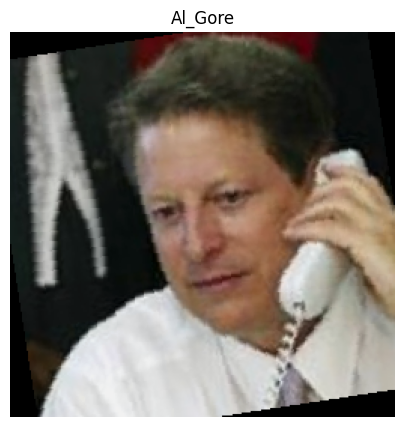

In [7]:
def denormalize(tensor):
    mean = torch.tensor(NORM_MEAN).view(3, 1, 1)
    std = torch.tensor(NORM_STD).view(3, 1, 1)
    return tensor * std + mean

image, label = train_ds[0]
image_denorm = denormalize(image)

plt.figure(figsize=(5, 5))
plt.imshow(image_denorm.permute(1, 2, 0))
plt.title(f'{train_ds.classes[label]}')
plt.axis('off')
plt.show()

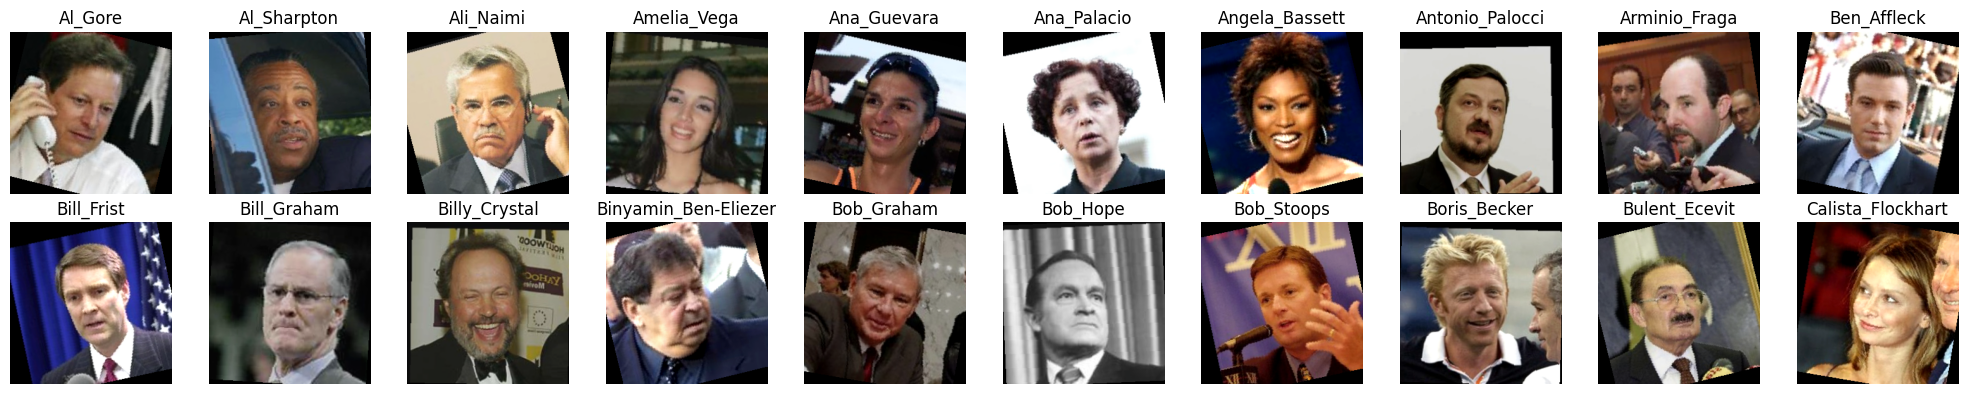

In [8]:
def plot_sample_images(dataset):
    rows = 2
    columns = 10
    count_photo = rows * columns

    fig, axes = plt.subplots(rows, columns, figsize=(20, 4))
    axes = axes.ravel()

    class_indices = {}
    for idx, (image, label) in enumerate(dataset):
        if label not in class_indices:
            class_indices[label] = idx
        if len(class_indices) == count_photo:
            break

    selected_indices = list(class_indices.values())[:count_photo]

    for i, idx in enumerate(selected_indices):
        image, label = dataset[idx]

        image_denorm = denormalize(image)

        axes[i].imshow(image_denorm.permute(1, 2, 0))
        axes[i].set_title(f"{dataset.classes[label]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images(train_ds)

Наконец, следует вывести распределение фотографий по людям и убедиться, что для каждого человека действительно предствалено 6-9 фотографий.

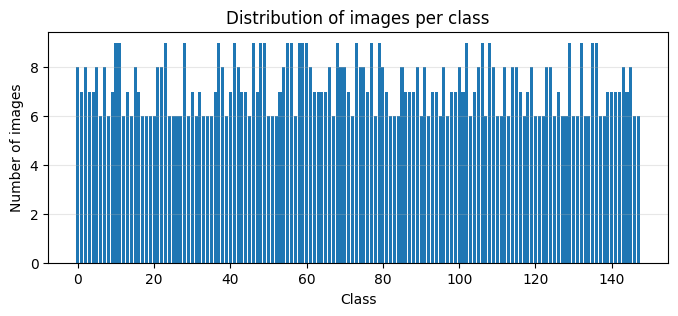

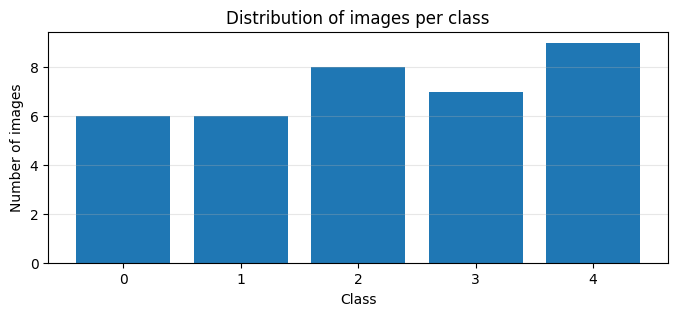

In [9]:
def show_class_distribtion(targets):
    unique, counts = numpy.unique(targets, return_counts=True)

    plt.figure(figsize=(8, 3))
    plt.bar(unique, counts)
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.title("Distribution of images per class")
    plt.grid(axis='y', alpha=0.3)

show_class_distribtion(train_ds.targets)
show_class_distribtion(test_ds.targets)

##### [0 баллов] Задание 1.2. Датасет пар.

Как было сказано ранее, мы будем обучать модели предсказывать, разные ли люди изображены на фотографиях. Для этого нам надо научиться формировать пары фотографий и целевую переменную из двух классов: 0 и 1. \
Класс 0 означает, что это фотографии одного человека. \
Класс 1 означает фотографии разных людей. \
 \
К счастью, весь датасет уже написан.

In [10]:
class PairDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.targets = [ self._get_target(i) for i in tqdm.trange(len(self)) ]

    def _idx1(self, idx):
        return idx % len(self.dataset)

    def _idx2(self, idx):
        return idx // len(self.dataset)

    def _get_target(self, idx):
        return int(self.dataset.targets[self._idx1(idx)] != self.dataset.targets[self._idx2(idx)])

    def __len__(self):
        return len(self.dataset) ** 2

    def __getitem__(self, idx):
        image1, label1 = self.dataset[self._idx1(idx)]
        image2, label2 = self.dataset[self._idx2(idx)]
        return image1, image2, int(label1 != label2)

train_pairs = PairDataset(train_ds)
test_pairs = PairDataset(test_ds)

100%|██████████| 1296/1296 [00:00<00:00, 923673.40it/s]


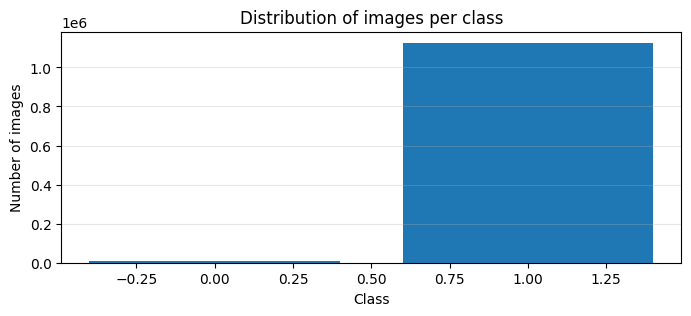

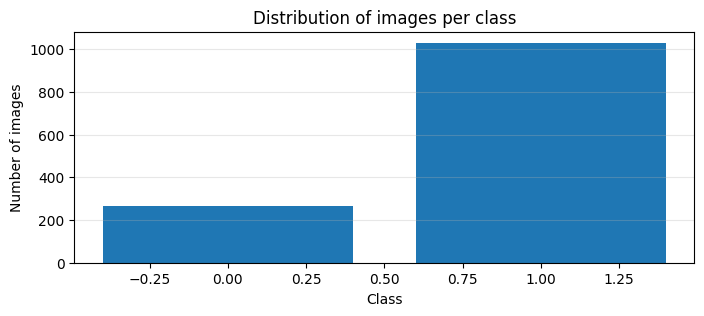

In [ ]:
show_class_distribtion(train_pairs.targets)
show_class_distribtion(test_pairs.targets)

Легко видеть, что пар фотографий разных людей гораздо больше, чем пар фотографий одного человека. Это вполне ожидаемо, но, если не предпринять мер, ведет к двум проблемам:
1. Метрика качества предсказаний должна учитывать дисбаланс классов. В частности, accuracy нам не подойдёт. А использовать будем известный из курса машинного обучения AUC-ROC.
2. Нужно "подтюнить" даталоадер тренировочных данных, чтобы в каждый батч попадало примерно одинаковое количество фотографий каждого класса. Иначе победить деградацию модели к "всегда 1" будет очень сложно.

##### [1 балл] Задание 1.3. Стратифицированный даталоадер.

Для начала решим вторую проблему. Нужно сделать такой даталоадер, чтобы в каждом батче количество элементов класса "0" совпадало с количеством элементов класса "1".

Как известно, стандартный класс `DataLoader` в torch имеет много параметров. В частности, параметр `sampler` позволяет гибко управлять выдачей. Изучите [документацию](https://docs.pytorch.org/docs/stable/data.html#data-loading-order-and-sampler) и реализуйте свой семплер, который решит проблему.

В `pytorch_metric_learning` уже есть готовая реализация того, что нам нужно. Вы можете её найти и использовать. Но в таком случае __максимальный балл за это задание - 0.4__.

In [11]:
class StratifiedSampler(torch.utils.data.Sampler):
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size

        self.class0_indices = [idx for idx in range(len(dataset)) if dataset.targets[idx] == 0]
        self.class1_indices = [idx for idx in range(len(dataset)) if dataset.targets[idx] == 1]

        self.num_class0 = len(self.class0_indices)
        self.num_class1 = len(self.class1_indices)

        self.samples_per_class = batch_size // 2
        self.num_batches = min(
            self.num_class0 // self.samples_per_class,
            self.num_class1 // self.samples_per_class
        )

    def __iter__(self):
        class0_shuffled = torch.randperm(self.num_class0).tolist()
        class1_shuffled = torch.randperm(self.num_class1).tolist()

        batches = []
        for batch_idx in range(self.num_batches):
            batch = []
            for i in range(self.samples_per_class):
                batch.append(self.class0_indices[class0_shuffled[batch_idx * self.samples_per_class + i]])
                batch.append(self.class1_indices[class1_shuffled[batch_idx * self.samples_per_class + i]])
            batches.extend(batch)

        return iter(batches)

    def __len__(self):
        return self.num_batches * self.batch_size


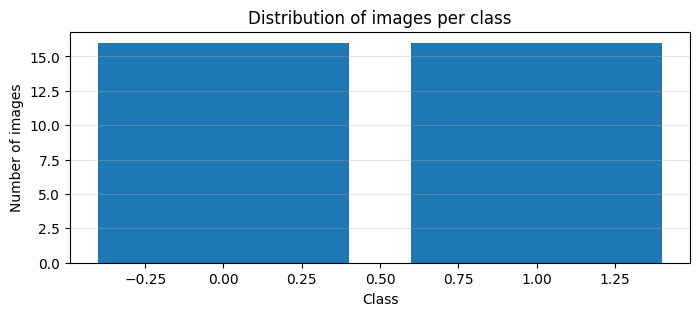

In [12]:
train_pairs_sampler = StratifiedSampler(train_pairs, batch_size=32)

train_pairs_loader = torch.utils.data.DataLoader(train_pairs, batch_size=32, sampler=train_pairs_sampler)
test_pairs_loader = torch.utils.data.DataLoader(test_pairs, batch_size=64, shuffle=False)

show_class_distribtion(next(iter(train_pairs_loader))[2])

### [3.5 балла] Часть 2. Классификация.

Начнём с простого: попробуем решить проблему как обычную задачу бинарной классификации. Реализуйте и обучите обычную свёрточную сеть, которая принимает два набора фотографий и предсказывает вероятность, что это фотографии разных людей.

##### [1 балл] Задание 2.1. Модель классификации.

Сначала нужно реализовать модель. В `forward` необходимо принять два батча фотографий. `i`-e число в выводе `forward` должно быть предсказанием для пары из `i`-й фотографии `image1` и `i`-й фотографии `image2`. Подумайте, как это сделать. Возможно, стоит как-нибудь склеить `image1` и `image2`? Или склеить эмбеддинги? А может быть нужен какой-то трешхолд?

Вы вольны использовать любую архитектуру сети. Ассерт в конце ячейки поможет вам убедиться, что модель теоретически делает то, что нужно.

In [ ]:
class ClassificationNet(torch.nn.Module):
    def __init__(self, embedding_size=512, num_classes=2):
        super().__init__()

        self.backbone = torchvision.models.resnet34(weights=None)
        self.backbone.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone.fc = nn.Identity()

        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, image1, image2):
        combined = torch.cat([image1, image2], dim=1)
        features = self.backbone(combined)
        output = self.classifier(features)
        return output.squeeze(1).float()

assert ClassificationNet()(*next(iter(train_pairs_loader))[:2]).shape == (32,)

##### [2 балла] Задание 2.2. Обучение.

Теперь обучите свою модель и добейтесь приемлемого качества. Балл за это задание вычисляется по формуле:

$$ clamp(0, 2.5 \cdot \dfrac{AucRoc - 0.6}{0.2}, 2.5) $$

То есть, для получения полного балла за это задание необходимо добиться AUC-ROC `0.8`

__При использовани предобученных моделей, балл за это задание умножается на 0.5__ (то есть, не более 1)

In [ ]:
def get_score(auc_roc):
    return max(0, min(2.5 * (auc_roc - 0.6) / 0.2, 2.5))

def get_auc_roc(model):
    preds = []
    targets = []
    model.eval()

    for images1, images2, labels in tqdm.tqdm(test_pairs_loader):
        with torch.no_grad():
            output = model(images1.to(device), images2.to(device))

        preds.extend(output.detach().cpu().tolist())
        targets.extend(labels.detach().cpu().tolist())

    preds = numpy.array(preds)
    targets = numpy.array(targets)
    return sklearn.metrics.roc_auc_score(targets, preds)

In [ ]:
def train_epoch(epoch, model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0

    for images1, images2, labels in tqdm.tqdm(dataloader, desc="Train"):
        images1, images2, labels = images1.to(device), images2.to(device), labels.to(device)
        labels = labels.float()

        # Forward
        optimizer.zero_grad()
        outputs = model(images1, images2)

        # Backward
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Metrics
        total_loss += loss.item()

    epoch_loss = total_loss / len(dataloader)
    auc_roc = get_auc_roc(model)

    print("┌" + "─" * 26 + "┐")
    print(f"│ Epoch\t│ Loss\t │ AUC-ROC │")
    print("├" + "─" * 26 + "┤")
    print(f"│ {epoch+1:3d}\t│ {epoch_loss:.4f} │ {auc_roc:.4f} │")
    print("└" + "─" * 26 + "┘\n")

    return epoch_loss, auc_roc

In [ ]:
model = ClassificationNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

num_epochs = 10
train_losses = []
train_auc_rocs = []

necessary_auc_roc = 0.8
best_auc_roc = 0.0
best_model = None

for epoch in range(num_epochs):
    # Train
    epoch_loss, epoch_auc_roc = train_epoch(epoch, model, train_pairs_loader, optimizer, criterion)
    train_losses.append(epoch_loss)
    train_auc_rocs.append(epoch_auc_roc)

    # Save the best model
    if epoch_auc_roc > best_auc_roc:
        best_auc_roc = epoch_auc_roc
        best_model = model.state_dict().copy()
        torch.save(best_model, 'best_model.pth')

if best_model is not None:
    model.load_state_dict(best_model)

final_auc_roc = get_auc_roc(model)
final_score = get_score(final_auc_roc)

print(f"\n\nFinal results:")
print(f"AUC-ROC: {final_auc_roc:.4f}")
print(f"Score: {final_score:.2f} from 2.5")

100%|██████████| 21/21 [00:11<00:00,  1.86it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC│
├──────────────────────────┤
│   1	│ 0.6264 │ 0.7944	│
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC│
├──────────────────────────┤
│   2	│ 0.5781 │ 0.7912	│
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC│
├──────────────────────────┤
│   3	│ 0.5407 │ 0.8179	│
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC│
├──────────────────────────┤
│   4	│ 0.5208 │ 0.8659	│
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC│
├──────────────────────────┤
│   5	│ 0.5025 │ 0.8913	│
└──────────────────────────┘



100%|██████████| 21/21 [00:10<00:00,  1.95it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC│
├──────────────────────────┤
│   6	│ 0.4856 │ 0.9014	│
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC│
├──────────────────────────┤
│   7	│ 0.4695 │ 0.9159	│
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC│
├──────────────────────────┤
│   8	│ 0.4597 │ 0.9190	│
└──────────────────────────┘



100%|██████████| 21/21 [00:10<00:00,  1.93it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC│
├──────────────────────────┤
│   9	│ 0.4461 │ 0.8897	│
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC│
├──────────────────────────┤
│  10	│ 0.4303 │ 0.9182	│
└──────────────────────────┘



100%|██████████| 21/21 [00:10<00:00,  1.92it/s]



Final results:
AUC-ROC: 0.9182
Score: 2.50 from 2.5


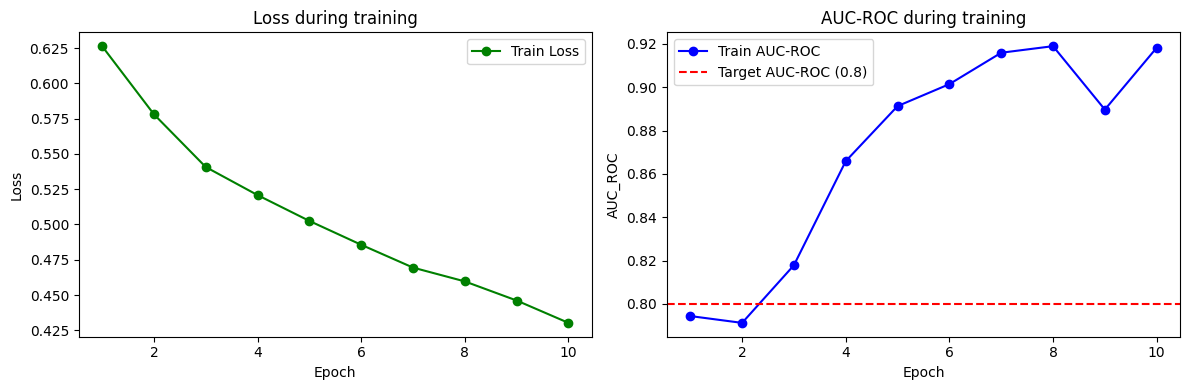

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, marker='o', color='green', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss during training')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_auc_rocs, marker='o', color='blue', label='Train AUC-ROC')
plt.axhline(y=necessary_auc_roc, linestyle='--', color='red', label='Target AUC-ROC (0.8)')
plt.xlabel('Epoch')
plt.ylabel('AUC_ROC')
plt.legend()
plt.title('AUC-ROC during training')

plt.tight_layout()
plt.show()

##### [0.5 балла] Задание 2.3. Анализ и отчет.

Опишите свои эксперименты. Проанализируйте результаты. Почему результаты получились не очень хорошими? Может быть, решать задачу через бинарную классификацию - не лучшая идея? Приведите не менее 3 аргументов, почему это так.

## Анализ экспериментов по бинарной классификации

### 1. Эксперимент с базовой архитектурой

**Архитектура модели:**
- Siamese-сеть с общим энкодером из 4 сверточных блоков
- Каждый блок: Conv2d → BatchNorm2d → ReLU → MaxPool2d
- Рост размерности: 3 → 32 → 64 → 128 → 256 каналов
- Комбинация признаков двух изображений: конкатенация исходных эмбеддингов, их абсолютной разницы и поэлементного произведения
- Классификатор: 3 линейных слоя (1024 → 512 → 128 → 1) с BatchNorm1d, ReLU, Dropout и Sigmoid

**Параметры обучения:**
- Оптимизатор: Adam (lr=0.001, weight_decay=1e-4)
- Scheduler: StepLR (step_size=10, gamma=0.5)
- Функция потерь: BCELoss
- Количество эпох: 10

**Результаты:**
- Время обучения: 30 минут
- Лучший показатель AUC-ROC: **0.69**

### 2. Эксперимент с усложненной архитектурой

**Улучшения архитектуры:**
- Увеличение глубины: каждый блок содержит два сверточных слоя вместо одного
- Рост размерности: 3 → 64 → 128 → 256 → 512 каналов
- Добавление Dropout2d в энкодер для регуляризации
- Увеличение размерности классификатора: 2048 → 1024 → 512 → 256 → 1

**Улучшения процесса обучения:**
- Оптимизатор: AdamW (lr=1e-4, weight_decay=1e-4)
- Scheduler: CosineAnnealingLR (T_max=20, eta_min=1e-6)
- Функция потерь: BCELoss
- Количество эпох: 30

**Результаты:**
- Время обучения: ~2 часа
- Лучший показатель AUC-ROC: **0.71**
- Прирост качества: +0.02 при значительном увеличении вычислительных затрат

### 3. Эксперимент с Resnet34

Эксперимент с архитектурой на основе ResNet34

**Архитектура модели:**

- Базовая сеть: ResNet34, модифицированная для приёма пар изображений
- Первый слой: изменён с 3 до 6 входных каналов для конкатенации двух RGB-изображений
- Классификатор: три полносвязных слоя (512 → 256 → 128 → 1) с BatchNorm1d, ReLU, Dropout (0.3 / 0.2) и Sigmoid
- Backbone: без предобученных весов, с заменой финального слоя на Identity

**Параметры обучения:**

- Оптимизатор: Adam (lr=0.001)
- Функция потерь: BCELoss
- Количество эпох: 10
- Сохранение лучшей модели по метрике AUC-ROC

**Результаты:**  
- Лучший показатель AUC-ROC: 0.91

### 4. Анализ проблем подхода бинарной классификации

**1. Неявное обучение метрики схожести**
Бинарная классификация заставляет сеть самостоятельно определять, какие признаки лиц являются дискриминативными и как их сравнивать. Модель учится различать конкрeтные пары "похожий/непохожий", но не формирует явную метрику расстояния в пространстве признаков. Это приводит к тому, что сеть может переобучиться на артефакты данных вместо обучения инвариантных к освещению, ракурсу и выражению лица признаков.

**2. Ограничения функции потерь BCELoss**
BCELoss оптимизирует разделение конкретных пар в тренировочном наборе, но не обеспечивает консистентности в пространстве признаков. Если лицо A похоже на B, и B похоже на C, это не гарантирует, что A будет похоже на C. Функция потерь не явно минимизирует расстояния между embedding'ами одного человека и не максимизирует расстояния между разными людьми.

**3. Несоответствие конечной цели**
Идеальная система верификации лиц должна проецировать все лица в единое метрическое пространство, где расстояние между эмбеддингами непосредственно отражает степень сходства. Бинарная классификация на парах решает эту задачу косвенно, через обучение классификатора, что приводит к субоптимальным embedding'ам. Подходы типа Triplet Loss или Contrastive Loss напрямую оптимизируют структуру пространства признаков, что делает их более подходящими для задач metric learning.

### [5 баллов] Часть 3. Распознавание лиц.

Теперь попробуем использовать более хитрые методы, которые лучше подходят для решаемой задачи. В частности, триплетную функцию потерь. Далее наша модель будет не предсказывать вероятность для двух картинок, а формировать эмбеддинги для одной картинки таким образом, чтобы эмбеддинги фотографий одного человека были близки, а разных людей - далеки.

##### [2 балла] Задание 3.1. Триплетная функция потерь.

Напомним теорию. Пусть $A$ - произвольное изображение; $P$ - изображение того же человека (позитивный пример); $N$ - изображение любого другого человека (негативный пример); $f$ - наша нейронная сеть; $\alpha$ - гиперпараметр, отвечающий за желаемый “отступ” – расстояние между латентными представлениями изображений разных людей. Тогда функционал ошибки определяется следующим образом:

$$ L(A, P, N) = max(||f(A) - f(P)|| - ||f(A) - f(N)|| + \alpha, 0) $$

В этом задании вам необходимо реализовать этот функционал. Для удобства в дальнейшем, предлагается сразу реализовать batch-версию. Таким образом, на входе должно быть 2 параметра:
- Набор эмбеддингов размера (batch_size, embedding_size)
- Набор классов (номера людей, чьи это фотографии) размера (batch_size)

Ваша функция должна найти все тройки $(A, P, N)$ и вычислить лосс для них.

В `pytorch_metric_learning` уже есть готовая реализация. Вы можете её найти и использовать. Но в таком случае __максимальный балл за это задание - 0.5__.

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super().__init__()
        self.margin = margin

    def forward(self, embeddings, labels):
        dists = torch.cdist(embeddings, embeddings, p=2)

        same_class_mask = labels.unsqueeze(0) == labels.unsqueeze(1)
        eye_mask = torch.eye(len(labels), dtype=torch.bool, device=embeddings.device)

        diff_class_mask = ~same_class_mask
        valid_positive_mask = same_class_mask & ~eye_mask

        positive_dists = dists.masked_fill(~valid_positive_mask, -float('inf'))
        hardest_positive_dist, _ = torch.max(positive_dists, dim=1)

        negative_dists = dists.masked_fill(~diff_class_mask, float('inf'))
        hardest_negative_dist, _ = torch.min(negative_dists, dim=1)

        loss = torch.relu(hardest_positive_dist - hardest_negative_dist + self.margin)

        valid_positive = hardest_positive_dist > -float('inf')
        valid_negative = hardest_negative_dist < float('inf')
        valid_triplets = valid_positive & valid_negative

        if valid_triplets.sum() > 0:
            return loss[valid_triplets].mean()
        else:
            return torch.tensor(0.0, device=embeddings.device, requires_grad=True)

In [ ]:
criterion = TripletLoss(margin=0.25)

In [ ]:
embeddings = torch.tensor([
    [ 1., 2, 3 ],
    [ 1, 3, 4 ],
    [ 4, 5, 6 ]
])
labels = torch.tensor([ 1., 2, 1 ])
assert (criterion(embeddings, labels) - 2.6775) < 1e-4

##### [3 балла] Задание 3.2. Обучение.

Теперь обучите модель и добейтесь приемлемого качества. Балл за это задание вычисляется по формуле:

$$ clamp(0, 3 \cdot \dfrac{AucRoc - 0.8}{0.15}, 3) $$

То есть, для получения полного балла за это задание необходимо добиться AUC-ROC `0.95`

При необходимости, вы можете улучшить функцию потерь. Например, учитывать не все тройки, а только "сложные", как это умеет делать реализация в `pytorch_metric_learning`. Также подумайте над даталоадером. Возможно, имеет смысл брать в батч одинаковое количество фотографий каждого человека по аналгии с заданием 1.3? Тем не менее имейте в виду, что для получения полного балла за задание, вы должны реализовать все модификации самостоятельно, а не использовать готовые.

__При использовани предобученных моделей, балл за это задание умножается на 0.5__ (то есть, не более 1.5) \
__При использовани pytorch_metric_learning, балл за это задание уменьшается на 0.5 за каждое использование__

In [14]:
class EmbeddingNet(nn.Module):
    def __init__(self, embedding_size=256, num_classes=None):
        super().__init__()

        base = torchvision.models.resnet18(weights=None)
        feat_dim = base.fc.in_features
        base.fc = nn.Identity()
        self.backbone = base

        self.embedding_block = nn.Sequential(
            nn.Linear(feat_dim, feat_dim),
            nn.BatchNorm1d(feat_dim),
            nn.ReLU(inplace=True),
            nn.Linear(feat_dim, embedding_size)
        )

        self.classifier = nn.Linear(embedding_size, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        embeddings = self.embedding_block(features)
        norm_embeddings = nn.functional.normalize(embeddings, p=2, dim=1)
        logits = self.classifier(embeddings)
        return norm_embeddings, logits

    def get_embeddings(self, x):
        self.eval()
        with torch.no_grad():
            features = self.backbone(x)
            embeddings = self.embedding_block(features)
            norm_embeddings = nn.functional.normalize(embeddings, p=2, dim=1)
        return norm_embeddings

In [15]:
class TripletSampler(torch.utils.data.Sampler):
    def __init__(self, dataset, n_classes, n_images):
        self.dataset = dataset
        self.n_classes = n_classes
        self.n_images = n_images

        self.class_indices = {}
        for idx, (_, label) in enumerate(dataset.samples):
            if label not in self.class_indices:
                self.class_indices[label] = []
            self.class_indices[label].append(idx)

        self.valid_classes = [
            c for c in self.class_indices
            if len(self.class_indices[c]) >= n_images
        ]

        self.n_batches = len(self.valid_classes) // n_classes

    def __iter__(self):
        classes = self.valid_classes.copy()
        random.shuffle(classes)

        for i in range(self.n_batches):
            batch_classes = classes[i * self.n_classes : (i + 1) * self.n_classes]
            batch_indices = []

            for c in batch_classes:
                indices = self.class_indices[c]
                images = random.sample(indices, self.n_images)
                batch_indices.extend(images)

            yield batch_indices

    def __len__(self):
        return self.n_batches

In [16]:
triplet_sampler = TripletSampler(train_ds, n_classes=16, n_images=4)

train_triplet_loader = torch.utils.data.DataLoader(train_ds, batch_sampler=triplet_sampler)

In [17]:
def get_score(auc_roc):
    return max(0, min(3 * (auc_roc - 0.8) / 0.15, 3))

def get_auc_roc(model):
    preds = []
    targets = []
    model.eval()
    for images1, images2, labels in tqdm.tqdm(test_pairs_loader):
        with torch.no_grad():
            img1 = images1.to(device)
            img2 = images2.to(device)
            emb1 = model.get_embeddings(img1)
            emb2 = model.get_embeddings(img2)
            dist = ((emb1 - emb2) ** 2).sum(dim = 1)
        preds.extend(dist.detach().cpu().tolist())
        targets.extend(labels.detach().cpu().tolist())
    preds = numpy.array(preds)
    targets = numpy.array(targets)
    return sklearn.metrics.roc_auc_score(targets, preds)

In [18]:
def train_loop(model, train_loader, num_epochs=50, lr=1e-3, weight_decay=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    triplet_coeff = 1.0
    ce_coeff = 0.5
    triplet_criterion = TripletLoss(margin=0.5)
    ce = nn.CrossEntropyLoss()

    train_losses = []
    train_auc_rocs = []
    best_auc = -1.0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for images, labels in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            labels = labels.to(device).long()

            # Forward
            optimizer.zero_grad()
            embeddings, logits = model(images)

            # Backward
            loss = triplet_coeff * triplet_criterion(embeddings, labels) + ce_coeff * ce(logits, labels)
            loss.backward()
            optimizer.step()

            # Metrics
            epoch_loss += loss.item()

        scheduler.step()
        average_loss = epoch_loss / len(train_loader)
        auc_roc = get_auc_roc(model)

        train_losses.append(average_loss)
        train_auc_rocs.append(auc_roc)

        # Print loss and AUC-ROC
        print("┌" + "─" * 26 + "┐")
        print(f"│ Epoch\t│ Loss\t │ AUC-ROC │")
        print("├" + "─" * 26 + "┤")
        print(f"│ {epoch+1:3d}\t│ {epoch_loss:.4f} │ {auc_roc:.4f}  │")
        print("└" + "─" * 26 + "┘\n")

        # Save the best model
        if auc_roc > best_auc:
            best_auc = auc_roc
            torch.save(model.state_dict(), "best_model.pth")

        if auc_roc > 0.95:
            break

    return best_auc, train_losses, train_auc_rocs

In [ ]:
set_random_seed(42)

num_classes = len(train_ds.classes)
num_epochs = 100

model = EmbeddingNet(embedding_size=256, num_classes=num_classes).to(device)

best_auc, train_losses, train_auc_rocs = train_loop(model, train_triplet_loader, num_epochs=num_epochs)

final_auc_roc = get_auc_roc(model)
final_score = get_score(final_auc_roc)

print(f"\n\nFinal results:")
print(f"AUC-ROC: {final_auc_roc:.4f}")
print(f"Score: {final_score:.2f} from 3")

100%|██████████| 21/21 [00:11<00:00,  1.79it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│   1	│ 32.0865 │ 0.5512  │
└──────────────────────────┘



100%|██████████| 21/21 [00:10<00:00,  1.94it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│   2	│ 30.1931 │ 0.5596  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│   3	│ 28.9704 │ 0.6681  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│   4	│ 28.6955 │ 0.6362  │
└──────────────────────────┘



100%|██████████| 21/21 [00:10<00:00,  1.92it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│   5	│ 28.3487 │ 0.6689  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.77it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│   6	│ 28.2096 │ 0.6732  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│   7	│ 28.0862 │ 0.7345  │
└──────────────────────────┘



100%|██████████| 21/21 [00:10<00:00,  1.93it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│   8	│ 27.8892 │ 0.7168  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│   9	│ 27.8423 │ 0.7613  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  10	│ 27.4397 │ 0.6794  │
└──────────────────────────┘



100%|██████████| 21/21 [00:10<00:00,  1.96it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  11	│ 27.0497 │ 0.8049  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  12	│ 26.6290 │ 0.8098  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  13	│ 26.1781 │ 0.8155  │
└──────────────────────────┘



100%|██████████| 21/21 [00:10<00:00,  1.94it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  14	│ 25.7733 │ 0.7833  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  15	│ 25.1492 │ 0.8166  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.86it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  16	│ 24.4125 │ 0.8760  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.87it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  17	│ 23.8142 │ 0.8723  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  18	│ 23.4628 │ 0.8223  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  19	│ 23.0866 │ 0.7854  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  20	│ 22.7097 │ 0.8350  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.88it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  21	│ 21.7843 │ 0.7814  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  22	│ 21.3773 │ 0.8788  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  23	│ 20.5443 │ 0.9014  │
└──────────────────────────┘



100%|██████████| 21/21 [00:10<00:00,  1.91it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  24	│ 20.1865 │ 0.8855  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  25	│ 19.4503 │ 0.8876  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  26	│ 18.6907 │ 0.9420  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.77it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  27	│ 18.2583 │ 0.9026  │
└──────────────────────────┘



100%|██████████| 21/21 [00:12<00:00,  1.73it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  28	│ 17.9218 │ 0.8886  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  29	│ 17.3749 │ 0.8738  │
└──────────────────────────┘



100%|██████████| 21/21 [00:10<00:00,  1.94it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  30	│ 17.1403 │ 0.9210  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  31	│ 16.3201 │ 0.9023  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  32	│ 15.4254 │ 0.8813  │
└──────────────────────────┘



100%|██████████| 21/21 [00:10<00:00,  1.94it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  33	│ 15.4299 │ 0.8824  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  34	│ 15.0348 │ 0.8628  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  35	│ 14.1102 │ 0.9192  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.91it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  36	│ 13.0388 │ 0.9291  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.85it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  37	│ 13.6655 │ 0.9289  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  38	│ 12.4204 │ 0.9143  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.87it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  39	│ 12.2511 │ 0.8955  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  40	│ 12.4896 │ 0.9017  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  41	│ 11.4602 │ 0.9056  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  42	│ 10.7430 │ 0.8857  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.88it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  43	│ 10.9430 │ 0.9151  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  44	│ 10.2745 │ 0.8841  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  45	│ 9.6281 │ 0.9167  │
└──────────────────────────┘



100%|██████████| 21/21 [00:10<00:00,  1.94it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  46	│ 9.5363 │ 0.9236  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  47	│ 9.6530 │ 0.8906  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  48	│ 9.1424 │ 0.9055  │
└──────────────────────────┘



100%|██████████| 21/21 [00:10<00:00,  1.96it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  49	│ 8.9475 │ 0.9048  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  50	│ 8.0178 │ 0.9080  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.85it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  51	│ 7.8349 │ 0.9394  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.89it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  52	│ 7.4728 │ 0.9122  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.90it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  53	│ 6.6355 │ 0.9416  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  54	│ 7.0046 │ 0.9061  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.85it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  55	│ 6.6475 │ 0.9122  │
└──────────────────────────┘



100%|██████████| 21/21 [00:10<00:00,  1.91it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  56	│ 6.3066 │ 0.9343  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  57	│ 6.5985 │ 0.9427  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  58	│ 6.3113 │ 0.9262  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.91it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  59	│ 6.0623 │ 0.9322  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  60	│ 6.0066 │ 0.9374  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  61	│ 5.4940 │ 0.9102  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.89it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  62	│ 5.3854 │ 0.9451  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.79it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  63	│ 5.0003 │ 0.9401  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.80it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  64	│ 5.1166 │ 0.9288  │
└──────────────────────────┘



100%|██████████| 21/21 [00:10<00:00,  1.94it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  65	│ 4.8656 │ 0.9479  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.86it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  66	│ 4.7483 │ 0.9378  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.87it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  67	│ 4.7720 │ 0.9491  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.90it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  68	│ 4.6573 │ 0.9368  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  69	│ 4.4543 │ 0.9359  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  70	│ 4.1267 │ 0.9491  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


┌──────────────────────────┐
│ Epoch	│ Loss	 │ AUC-ROC │
├──────────────────────────┤
│  71	│ 4.3775 │ 0.9519  │
└──────────────────────────┘



100%|██████████| 21/21 [00:11<00:00,  1.80it/s]



Final results:
AUC-ROC: 0.9519
Score: 3.00 from 3


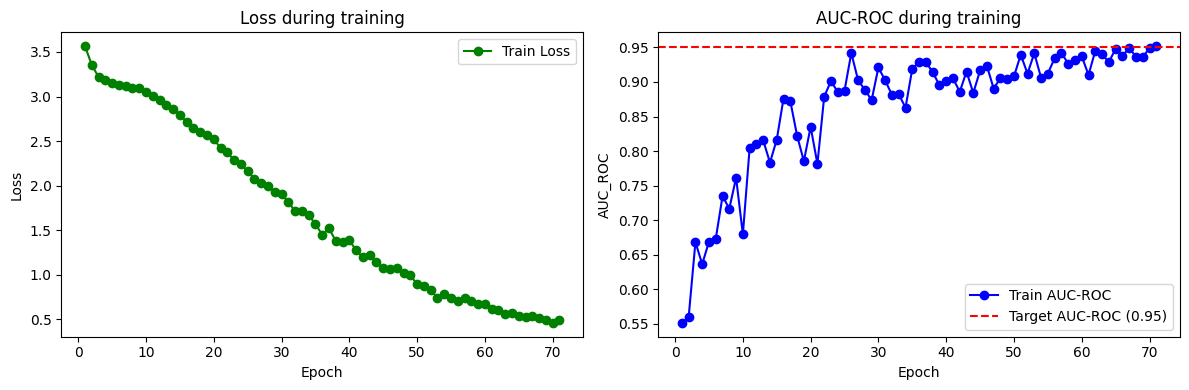

In [ ]:
necessary_auc_roc = 0.95

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, 72), train_losses, marker='o', color='green', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss during training')

plt.subplot(1, 2, 2)
plt.plot(range(1, 72), train_auc_rocs, marker='o', color='blue', label='Train AUC-ROC')
plt.axhline(y=necessary_auc_roc, linestyle='--', color='red', label=f'Target AUC-ROC ({necessary_auc_roc})')
plt.xlabel('Epoch')
plt.ylabel('AUC_ROC')
plt.legend()
plt.title('AUC-ROC during training')

plt.tight_layout()
plt.show()

##### [0.1 балла] Бонус: распознай себя

В качестве бонуса, загрузите свою фотографию (можно не одну), пропустите ее через модель и определите, на кого из известных людей, по мнению модели, вы больше всего похоже.

In [ ]:
def load_image_from_url(url, transform):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return transform(img)

my_urls = [
    "https://raw.githubusercontent.com/vasyukov1/iad-deep-learning/refs/heads/main/hw_02_segmentation/me_04.jpg",
    "https://raw.githubusercontent.com/vasyukov1/iad-deep-learning/refs/heads/main/hw_02_segmentation/me_03.jpg",
    "https://raw.githubusercontent.com/vasyukov1/iad-deep-learning/refs/heads/main/hw_02_segmentation/me_02.jpg",
    "https://raw.githubusercontent.com/vasyukov1/iad-deep-learning/refs/heads/main/hw_02_segmentation/me_01.jpg"
]

model = EmbeddingNet(embedding_size=256, num_classes=num_classes).to(device)

try:
    if os.path.exists("best_model.pth"):
        model.load_state_dict(torch.load("best_model.pth", map_location='cpu'))
        # Либо 'cuda' в map_location, если не будет работать
        # Просто я уже устал переключать аккаунты гугла и перезапускать всё...(
        print("Model loaded successfully!")
    else:
        print("Model file not found. Using randomly initialized model.")
except Exception as e:
    print(f"Error loading model: {e}")

model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

my_images = torch.stack([load_image_from_url(url, test_transform) for url in my_urls]).to(device)
my_embeddings = model.get_embeddings(my_images)

Model loaded successfully!
my_embeddings: torch.Size([4, 256])


In [44]:
loader = DataLoader(train_ds, batch_size=64, shuffle=False)
embeddings = []
labels = []

with torch.no_grad():
    for images, batch_labels in tqdm.tqdm(loader, desc="Computing embeddings"):
        images = images.to(device)
        emb = model.get_embeddings(images)
        embeddings.append(emb.cpu())
        labels.extend(batch_labels.cpu())

embeddings = torch.cat(embeddings)
labels = torch.tensor(labels)

Computing embeddings: 100%|██████████| 17/17 [00:08<00:00,  1.89it/s]


In [49]:
def find_top_similar(my_embeddings, embeddings, top_k=5):
    device = embeddings.device
    my_embeddings = my_embeddings.to(device)
    embeddings = embeddings.to(device)

    sims = F.cosine_similarity(my_embeddings.unsqueeze(0), embeddings)
    topk_values, topk_idinces = sims.topk(top_k, largest=True)
    return topk_idinces, topk_values

def show_similar_faces(my_image_tensor, indices, dataset, sims, title_prefix=""):
    n_cols = len(indices) + 1
    plt.figure(figsize=(3 * n_cols, 3))
    my_image = denormalize(my_image_tensor.cpu()).permute(1, 2, 0)
    plt.subplot(1, n_cols, 1)
    plt.imshow(my_image)
    plt.title(f"{title_prefix}")
    plt.axis('off')

    for i, (idx, sim) in enumerate(zip(indices, sims)):
        image, label = dataset[idx]
        image = denormalize(image).permute(1, 2, 0)
        plt.subplot(1, n_cols, i + 2)
        plt.imshow(image)
        plt.title(f"{dataset.classes[label]}\n(sim={sim:.2f})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

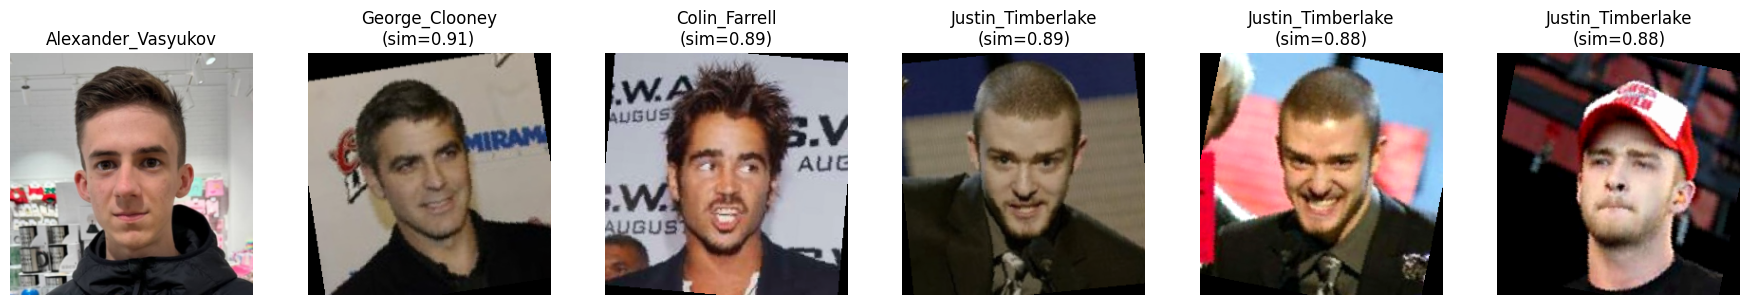

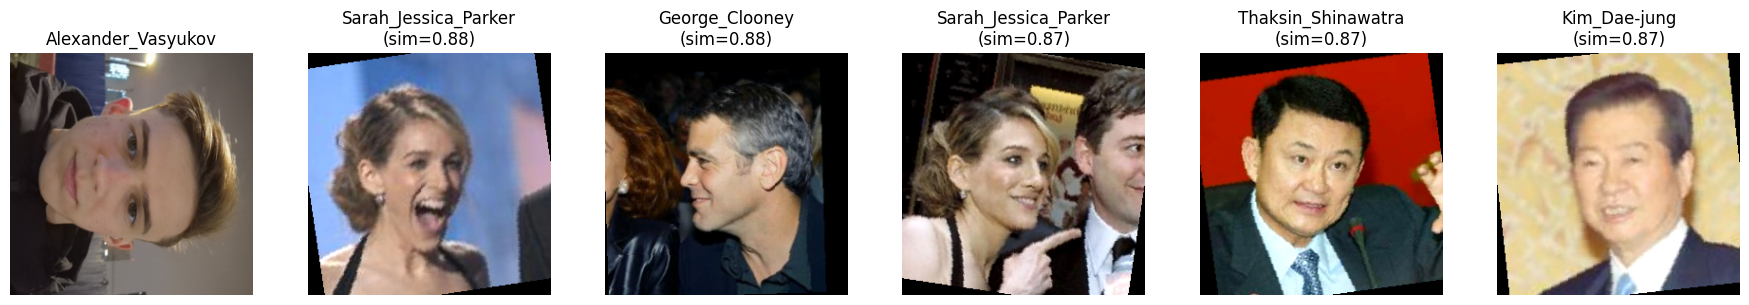

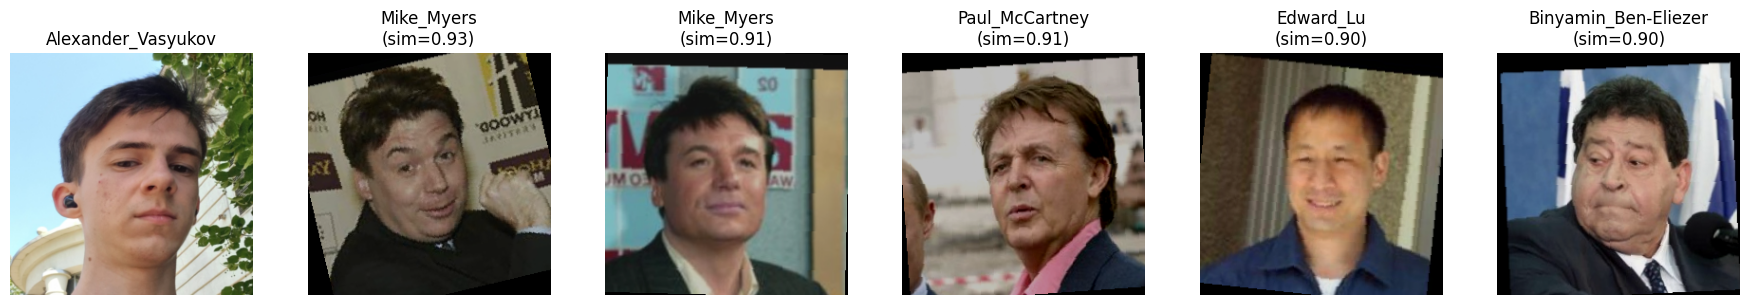

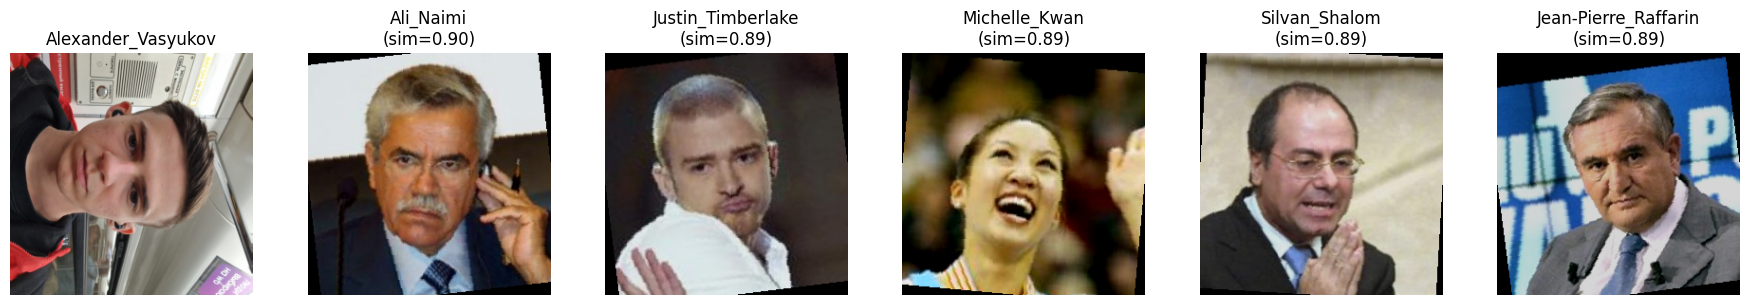

In [50]:
for i, my_embedding in enumerate(my_embeddings):

    indices, sims = find_top_similar(my_embedding, embeddings, top_k=5)
    for rank, (index, sim) in enumerate(zip(indices, sims), 1):
        path, label = train_ds.samples[index]

    show_similar_faces(my_images[i], indices, train_ds, sims, title_prefix="Alexander_Vasyukov")
